In [1]:
#!/usr/bin/env python
# coding: utf-8

In[16]:

In [2]:
import keras
import os
import tempfile
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.inspection import permutation_importance
import tensorflow as tf
import time
import pandas as pd
import seaborn as sns
import csv
from sklearn.preprocessing import StandardScaler

In [3]:
from keras import optimizers, metrics
from keras import activations
from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add

In [4]:
from constants import column_labels_particle_assignment_btags as column_names

In[17]:


Data augmentation functions. Rotate all particles of an event (or a permutation of an event) by a random angle. 

In [5]:

def random_rotation(X,deltas_phi,num_vectors,met):
	for i in range(num_vectors):
		R = np.sqrt((X[:,4*i+0]**2 + X[:,4*i+1]**2))
		old_phis = np.arctan2(X[:,4*i+1],X[:,4*i+0])
		new_phis = old_phis + deltas_phi
		angles_sin = np.sin(new_phis)
		angles_cos = np.cos(new_phis)
		X[:,4*i+0] = angles_cos * R
		X[:,4*i+1] = angles_sin * R
	if met:
		return random_rotation_MET(X, deltas_phi)
	else:
		return X
def random_rotation_MET(X, deltas_phi):
	# Indices based on the data files structure.
	met_x_index = -6
	met_y_index = -5
	R = np.sqrt((X[:,met_x_index]**2 + X[:,met_y_index]**2))
	old_phis = np.arctan2(X[:,met_y_index],(X[:,met_x_index]))
	new_phis = old_phis + deltas_phi
	angles_sin = np.sin(new_phis)
	angles_cos = np.cos(new_phis)
	X[:,met_x_index] = angles_cos * R
	X[:,met_y_index] = angles_sin * R
	return X
def data_rotation(X, num_vectors_X = 11, met = True):
	deltas_phi = np.random.rand(X.shape[0])*2*math.pi
	X = random_rotation(X,deltas_phi,num_vectors_X,met)
	return X
# Data generator class. Used to serve data to the neural network.

In [6]:
# Modified from source https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
class DataGenerator(keras.utils.Sequence):
	# NUMBER OF FEATURES ORIGINALLY 67
	def __init__(self, list_IDs, labels, batch_size=32, n_features=67, shuffle=True, scaler = "../scaler_params/particle_assignment_scaler_params.csv", data_path = "data/particle_assignment_training_data/data/", with_ids = False, augmentation = False):
		self.n_features = n_features
		self.batch_size = batch_size
		self.labels = labels
		self.list_IDs = list_IDs
		self.shuffle = shuffle
		self.data_path = data_path
		self.with_ids = with_ids
		self.augmentation = augmentation
		with open(scaler) as f:
			scaler_params = np.loadtxt(f, delimiter=",")
			self.scaler = scaler_params
		self.on_epoch_end()
	def __len__(self):
		'Denotes the number of batches per epoch'
		return int(np.ceil(len(self.list_IDs) / self.batch_size))
	def __getitem__(self, index):
		'Generate one batch of data'
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
		# Find list of IDs
		list_IDs_temp = [self.list_IDs[k] for k in indexes]
		# Generate data
		X, y, weights = self.__data_generation(list_IDs_temp)
		return X, y, weights
	def on_epoch_end(self):
		'Updates indexes after each epoch'
		self.indexes = np.arange(len(self.list_IDs))
		if self.shuffle == True:
			np.random.shuffle(self.indexes)
	def __data_generation(self, list_IDs_temp):
		'Generates data containing batch_size samples as X : (n_samples, *dim, n_channels)'
		# Initialization<br>
		X = np.zeros((1,self.n_features),dtype=float)
		y = np.zeros((1,5),dtype=int)
		for i, ID in enumerate(list_IDs_temp):
			# print(str(int(ID)) + '.npy')
			# print(np.load(self.data_path + str(int(ID)) + '.npy'))
			# print(len(np.load(self.data_path + str(int(ID)) + '.npy')[0]))
			# print(X.shape,np.load(self.data_path + str(int(ID)) + '.npy').shape)
			X = np.concatenate((X,np.load(self.data_path + str(int(ID)) + '.npy')),axis=0)
			y = np.concatenate((y,self.labels[str(int(ID))]),axis=0)
		# print("shape before:")
		# print(X)
		# print(column_names)
		print("TYPE OF THE SELF.SCALER")
		print(type(self.scaler))
		scaler = np.copy(self.scaler)

		X = X[1:,:column_names.index("true main px")]       # Get rid of the init row. Get rid of information you do not want to use (truth information).
		scaler = scaler[:,:column_names.index("true main px")]       # Get rid of the init row. Get rid of information you do not want to use (truth information).

		print("PRINTING ORIGINAL X AND ITS SHAPE")
		print(X)
		print(X.shape)
		global feature_names
		feature_names = column_names
		feature_names = feature_names[ :column_names.index("true main px")]
		# trying to take out the least important features here
		# K = "main lepton pz"
		# J = 0
		# while(K in feature_names):
		# 	feature_names.remove(K)
		# 	J = J+1
		
		# X = np.delete(X, J, axis=0)
		# print(X)
		# print(X.shape)
		
		# self.n_features = self.n_features -1

		# DONT FORGET TO SLICE THE SCALER HERE TOO WHEN YOU TAKE OUT THE FEATURE
		feature_names_np = np.array(feature_names)
		bad_feature_names = np.array(["main lepton pz", "HT"]) # -> 1,2 ???

		indices = []

		for feature in bad_feature_names:
			print(feature)
			print(feature_names_np)
			print("/n")
			# indices.append(np.where(feature_names_np != feature)[0][0])
			indices.append(np.where(feature not in feature_names_np)[0][0])
			
			# if feature not in feature_names_np:
			# 	indices.append

		X = X[:,indices]
		print("PRINTING INDICES")
		print(indices)
		# not entirely sure if this will remove correctly,, may need to remove the colon or use a different notation on line 87
		# feature_names = feature_names[:indices] # WHY WONT THIS WORK WITH ADVANCED INDEXING,, bc it's technically not a numpy array
		for index in indices:
			feature_names.pop(index)

		scaler = scaler[:,indices]
		print("PRINTING X.SHAPE AFTER FEATURE REMOVAL")
		print(X.shape)


		print(feature_names)
		print("/n")
		# print(X.shape)
		y = y[1:,:]                                         # Get rid of the init row.
		weights = np.reciprocal(X[:,-1])*200        # Sample weights are based on the number of permutations of an event - more permutations means smaller sample weight.
		X = X[:,:-1]        # Get rid of weights column.
		scaler = scaler[:,:-1]        # Get rid of weights column.
		feature_names = feature_names[:-1]
		if self.with_ids:
			X = np.concatenate((X[:,0].reshape(len(X[:,0]),1),(X[:,1:]-self.scaler[0])/self.scaler[1]), axis = 1)   # Standardize everything except for EVENT IDS...
		else:
			X = X[:,1:]        # Get rid of EVENT ID column.
			scaler = scaler[:,1:]        # Get rid of EVENT ID column.
			feature_names = feature_names[1:]
		if self.augmentation:
			X = data_rotation(X, num_vectors_X = 11, met = True)
		if self.with_ids:
			pass
		else:
			# print("shape:")
			# VV this has second dimension to be 65 but the other chapes are 67, is that part of the problem
			# print(self.scaler.shape)
			# comment out when you do the scalar
			# X = (X-self.scaler[0])/self.scaler[1]     # Standardize X=X
			X = (X-scaler[0])/scaler[1]     # Standardize X=X
			# X=X
		# print(X.shape)
		return X, y, weights
	def get_all(self):
		X = []
		y = []
		for i in range(self.__len__()):
			X_y = self.__getitem__(i)
			X += X_y[0].tolist()
			y += X_y[1].tolist()
		X = np.array(X)
		y = np.array(y)
		print("finished get all")
		return X, y
# In[18]:
#Load data from files. 


In [7]:
with open("../data/particle_assignment_training_data/labels_dict_ttH.csv") as f:
	lines_ttH = f.readlines()
# with open("data/particle_assignment_training_data/labels_dict_ttZ.csv") as f:
#     lines_ttZ = f.readlines()

In [8]:
with open("../data/particle_assignment_training_data/train_ids_ttH.csv") as f:
	train_ids_ttH = np.loadtxt(f, delimiter=",")
# with open("data/particle_assignment_training_data/train_ids_ttZ.csv") as f:
#     train_ids_ttZ = np.loadtxt(f, delimiter=",")

In [9]:
with open("../data/particle_assignment_training_data/test_ids_ttH.csv") as f:
	test_ids_ttH = np.loadtxt(f, delimiter=",")
# with open("data/particle_assignment_training_data/test_ids_ttZ.csv") as f:
#     test_ids_ttZ = np.loadtxt(f, delimiter=",")

In [10]:
with open("../data/particle_assignment_training_data/val_ids_ttH.csv") as f:
	val_ids_ttH = np.loadtxt(f, delimiter=",")
# with open("data/particle_assignment_training_data/val_ids_ttZ.csv") as f:
#     val_ids_ttZ = np.loadtxt(f, delimiter=",")
#
# train_ids = np.concatenate((train_ids_ttH,train_ids_ttZ), axis = 0)
# test_ids = np.concatenate((test_ids_ttH,test_ids_ttZ), axis = 0)
# val_ids = np.concatenate((val_ids_ttH,val_ids_ttZ), axis = 0)
# lines = np.concatenate((lines_ttH,lines_ttZ), axis = 0)

NEXT FOUR LINES ADDED BY EMILY

In [11]:
train_ids = train_ids_ttH
test_ids = test_ids_ttH
val_ids = val_ids_ttH
lines = lines_ttH
print("\n")
print(train_ids)
print(len(train_ids))
print(len(test_ids))
print(len(val_ids))
print(len(lines))



[1250001. 1250002. 1250003. 1250004. 1250005. 1250006. 1250007. 1250009.
 1250011. 1250012. 1250013. 1250014. 1250015. 1250016. 1250018. 1250019.
 1250020. 1250021. 1250023. 1250024. 1250025. 1250027. 1250028. 1250029.
 1250030. 1250032. 1250033. 1250034. 1250035. 1250037. 1250038. 1250039.
 1250040. 1250041. 1250043. 1250044. 1250045. 1250046. 1250048. 1250049.
 1250050. 1250051. 1250053. 1250054. 1250056. 1250057. 1250058. 1250059.
 1250060. 1250062. 1250063. 1250064. 1250065. 1250066. 1250068. 1250069.
 1250070. 1250071. 1250073. 1250074. 1250075. 1250077. 1250078. 1250079.
 1250080. 1250081. 2250001. 2250002. 2250003. 2250004. 2250005. 2250007.
 2250008. 2250010. 2250011. 2250012. 2250013. 2250014. 2250015. 2250017.
 2250018. 2250019. 2250021. 2250022. 2250023. 2250024. 2250026. 2250027.
 2250028. 2250029. 2250031. 2250032. 2250033. 2250034. 2250035. 2250036.
 2250038. 2250039. 2250040. 2250042. 2250043. 2250044. 2250045. 2250047.
 2250048. 2250049. 2250051. 2250052. 2250053. 225

In [12]:
print("\n")

In [13]:
labels_dict = {}

In [14]:
for line in lines:
	row = np.fromstring(line, dtype=float, sep=',')
	key = str(int(row[0]))
	value = (row[1:]).reshape((int(len(row[1:])/5),5))
	labels_dict[key] = value

In [15]:
print(labels_dict)

{'1250001': array([[0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       ...,
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.]]), '1250002': array([[1., 1., 0., 0., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 1.],
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1.]]), '1250003': array([[0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.],
       ...,
       [1., 0., 0., 1., 1.],
       [1., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1.]]), '1250004': array([[0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 1.],
       [0., 1., 1., 0., 0.],
       ...,
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 1., 1., 1., 1.]]), '1250005': array([[1., 0., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       ...,
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 0.]]), '125

In [16]:
print(len(labels_dict))
# training_generator = DataGenerator(train_ids, labels_dict, shuffle=True, with_ids=False, augmentation = True, data_path="../data/particle_assignment_training_data/data/")
training_generator = DataGenerator(train_ids, labels_dict, shuffle=True, with_ids=False, augmentation = False, data_path="../data/particle_assignment_training_data/data/")
validation_generator = DataGenerator(val_ids, labels_dict, with_ids=False, augmentation = False, data_path="../data/particle_assignment_training_data/data/")
testing_generator = DataGenerator(test_ids, labels_dict, shuffle=False, with_ids=False, augmentation = False, data_path="../data/particle_assignment_training_data/data/")

244


In [17]:
# NEW SCALAR TRAINING, NEED TO RUN AGAIN WHEN YOU CHANGE THE NUMBER OF INITIAL FEATURES (IN csv)
# comment out line at the end of the training generator when you run this as well
# training_gen_X, training_gen_Y = training_generator.get_all()

scaler = StandardScaler()
scaler.fit(training_gen_X)

f = open("../scaler_params/particle_assignment_scaler_params.csv", "w")
writer = csv.writer(f)
writer.writerow(scaler.mean_)
writer.writerow(scaler.scale_)
f.close()

In[19]:

In [18]:
#Count all training samples. 
num_samples = 0
for i in range(len(training_generator)):
	num_samples += len(training_generator[i][0])
# In[20]:
#Get scaler params from training data. 


TYPE OF THE SELF.SCALER
<class 'numpy.ndarray'>
PRINTING ORIGINAL X AND ITS SHAPE
[[2.57053830e+07 3.20660356e+04 6.46497867e+04 ... 4.97743938e+05
  3.00000000e+01 4.56000000e+02]
 [2.57053830e+07 3.20660356e+04 6.46497867e+04 ... 4.97743938e+05
  3.00000000e+01 4.56000000e+02]
 [2.57053830e+07 3.20660356e+04 6.46497867e+04 ... 4.97743938e+05
  3.00000000e+01 4.56000000e+02]
 ...
 [2.93419690e+07 3.98208804e-02 9.99206834e-01 ... 3.02276031e+05
  1.00000000e+01 4.56000000e+02]
 [2.93419690e+07 3.98208804e-02 9.99206834e-01 ... 3.02276031e+05
  1.00000000e+01 4.56000000e+02]
 [2.93419690e+07 3.98208804e-02 9.99206834e-01 ... 3.02276031e+05
  1.00000000e+01 4.56000000e+02]]
(61656, 63)
main lepton pz
['event id' 'top b px' 'top b py' 'top b pz' 'top b E' 'antitop b px'
 'antitop b py' 'antitop b pz' 'antitop b E' 'top W px' 'top W py'
 'top W pz' 'top W E' 'main lepton px' 'main lepton py' 'main lepton pz'
 'main lepton E' 'antitop lepton px' 'antitop lepton py'
 'antitop lepton pz' 'an

IndexError: index 0 is out of bounds for axis 0 with size 0

ONLY NEED TO TRAIN THIS ONCE PER TIME YOU HAVE NEW DATA

In [ ]:
X_train = np.empty((num_samples,61), dtype=float)
c = 0

In [ ]:
for i in range(len(training_generator)):
	rows = len(training_generator[i][0][:])
	X_train[c:c+rows,:] = training_generator[i][0][:]
	c += rows


TYPE OF THE SELF.SCALER
<class 'numpy.ndarray'>
PRINTING ORIGINAL X AND ITS SHAPE
[[ 2.61219100e+07  9.75383340e+04 -3.06818749e+04 ...  4.80627875e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.61219100e+07  9.75383340e+04 -3.06818749e+04 ...  4.80627875e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.61219100e+07  9.75383340e+04 -3.06818749e+04 ...  4.80627875e+05
   1.00000000e+01  2.40000000e+02]
 ...
 [ 2.61631460e+07  2.74083993e+04 -1.43067653e+04 ...  4.17912031e+05
   3.00000000e+01  4.56000000e+02]
 [ 2.61631460e+07  2.74083993e+04 -1.43067653e+04 ...  4.17912031e+05
   3.00000000e+01  4.56000000e+02]
 [ 2.61631460e+07  2.74083993e+04 -1.43067653e+04 ...  4.17912031e+05
   3.00000000e+01  4.56000000e+02]]
(62064, 63)
main lepton pz
['event id' 'top b px' 'top b py' 'top b pz' 'top b E' 'antitop b px'
 'antitop b py' 'antitop b pz' 'antitop b E' 'top W px' 'top W py'
 'top W pz' 'top W E' 'main lepton px' 'main lepton py' 'main lepton pz'
 'main lepton E' 'antitop lepton px' 'antitop

ValueError: could not broadcast input array from shape (62064,0) into shape (62064,61)

In [ ]:
X_train = X_train[1:,:]
print("XTRAIN SIZE")
print(X_train.shape)
# scaler = StandardScaler()
# scaler.fit(X_train)
#
# f = open("../scaler_params/particle_assignment_scaler_params.csv", "w")
# writer = csv.writer(f)
# writer.writerow(scaler.mean_)
# writer.writerow(scaler.scale_)
# f.close()

XTRAIN SIZE
(372239, 61)


In [ ]:
# Get intial biases and weights for the unbalanced classification problem. 
y_train = np.empty((num_samples,5), dtype=int)
c = 0
for i in range(len(training_generator)):
	rows = len(training_generator[i][1][:])
	y_train[c:c+rows,:] = training_generator[i][1][:]
	c += rows
y_train = y_train[1:,:]
print("PRINTING y_train")
print(y_train)
correct = np.count_nonzero(y_train, axis=0)
incorrect = np.ones(5)*y_train.shape[0] - correct
total = correct + incorrect
initial_bias = np.log([correct/incorrect])
initial_bias = initial_bias.flatten()
correct_weight = (total /2/correct)
incorrect_weight = (total /2/incorrect)
weights_means = (correct_weight + incorrect_weight)/2
correct_weight /= weights_means
incorrect_weight /= weights_means
class_weight = [{0: incorrect_weight[i], 1: correct_weight[i]} for i in range(len(correct_weight))]
class_weight_arr = np.concatenate((correct_weight,incorrect_weight))
class_weight_arr = np.reshape(class_weight_arr, (2,5))
print(class_weight_arr)
# In[22]:
# Loss function for unbalanced classification. 
# source: https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy

[[ 2.40253040e+07 -1.70487950e+04 -2.26280694e+04 ...  7.63309938e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.40253040e+07 -1.70487950e+04 -2.26280694e+04 ...  7.63309938e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.40253040e+07 -1.70487950e+04 -2.26280694e+04 ...  7.63309938e+05
   1.00000000e+01  2.40000000e+02]
 ...
 [ 2.57062230e+07 -2.13232123e+04  2.70505967e+04 ...  3.16825625e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.57062230e+07 -2.13232123e+04  2.70505967e+04 ...  3.16825625e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.57062230e+07 -2.13232123e+04  2.70505967e+04 ...  3.16825625e+05
   1.00000000e+01  2.40000000e+02]]
(61680, 63)
['event id', 'top b px', 'top b py', 'top b pz', 'top b E', 'antitop b px', 'antitop b py', 'antitop b pz', 'antitop b E', 'top W px', 'top W py', 'top W pz', 'top W E', 'main lepton px', 'main lepton py', 'main lepton pz', 'main lepton E', 'antitop lepton px', 'antitop lepton py', 'antitop lepton pz', 'antitop lepton E', 'top W q1 px', 'top W q1 py'

In [ ]:
def create_weighted_binary_crossentropy(ones_weights,zeros_weights):

	def weighted_binary_crossentropy(y_true, y_pred):

		b_ce = K.binary_crossentropy(y_true, y_pred)
		weight_vector = y_true * ones_weights + (1. - y_true) * zeros_weights
		weighted_b_ce = weight_vector * b_ce

		return K.mean(weighted_b_ce)

	return weighted_binary_crossentropy

In [ ]:
"""Metrics."""
from keras.regularizers import l2
# source: https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras<br>
def custom_f1(y_true, y_pred):
	def recall_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
		recall = TP / (Positives+K.epsilon())
		return recall
	def precision_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
		precision = TP / (Pred_Positives+K.epsilon())
		return precision
	precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
	return 2*((precision*recall)/(precision+recall+K.epsilon()))
# source: https://stackoverflow.com/questions/39895742/matthews-correlation-coefficient-with-keras
def matthews_correlation(y_true, y_pred):
	y_pred_pos = K.round(K.clip(y_pred, 0, 1))
	y_pred_neg = 1 - y_pred_pos
	y_pos = K.round(K.clip(y_true, 0, 1))
	y_neg = 1 - y_pos
	tp = K.sum(y_pos * y_pred_pos)
	tn = K.sum(y_neg * y_pred_neg)
	fp = K.sum(y_neg * y_pred_pos)
	fn = K.sum(y_pos * y_pred_neg)
	numerator = (tp * tn - fp * fn)
	denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
	return numerator / (denominator + K.epsilon())
METRICS = [
	  keras.metrics.TruePositives(name='tp'),
	  keras.metrics.FalsePositives(name='fp'),
	  keras.metrics.TrueNegatives(name='tn'),
	  keras.metrics.FalseNegatives(name='fn'),
	  keras.metrics.BinaryAccuracy(name='accuracy'),
	  keras.metrics.Precision(name='precision'),
	  keras.metrics.Recall(name='recall'),
	  keras.metrics.AUC(name='auc'),
	  keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
	  matthews_correlation,
	  custom_f1,
]

In [ ]:

""" NN architecture defined in this model. """

def lep_assignment_model(num_features=42, bias = None):
	if bias is not None:
		bias1 = tf.keras.initializers.Constant(bias[0])
		bias2 = tf.keras.initializers.Constant(bias[1])
		bias3 = tf.keras.initializers.Constant(bias[2])
		bias4 = tf.keras.initializers.Constant(bias[3])
		bias5 = tf.keras.initializers.Constant(bias[4])

	i = keras.Input(shape = (num_features,))

	dropout_1 = Dropout(0.2)(i)
	dense_1 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_1)
	relu_1 = Activation(activations.relu)(dense_1)

	dropout_2 = Dropout(0.2)(relu_1)
	dense_2 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_2)
	relu_2 = Activation(activations.relu)(dense_2)

	dropout_3 = Dropout(0.2)(relu_2)
	dense_3 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_3)
	add_1 = Add()([dense_3,dense_1])
	relu_3 = Activation(activations.relu)(add_1)

	dropout_4 = Dropout(0.2)(relu_3)
	dense_4 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_4)
	relu_4 = Activation(activations.relu)(dense_4)

	dropout_5 = Dropout(0.2)(relu_4)
	dense_5 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_5)
	add_2 = Add()([dense_5,add_1])
	relu_5 = Activation(activations.relu)(add_2)

	dropout_6 = Dropout(0.2)(relu_5)
	dense_6 = Dense(500, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_6)
	relu_6 = Activation(activations.relu)(dense_6)

	dropout_7 = Dropout(0.2)(relu_6)
	o1 = Dense(1, activation='sigmoid', bias_initializer=bias1, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
	o2 = Dense(1, activation='sigmoid', bias_initializer=bias2, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
	o3 = Dense(1, activation='sigmoid', bias_initializer=bias3, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
	o4 = Dense(1, activation='sigmoid', bias_initializer=bias4, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
	o5 = Dense(1, activation='sigmoid', bias_initializer=bias5, kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(dropout_7)
	o = keras.layers.Concatenate(axis=1)([o1,o2,o3,o4,o5])

	model = keras.Model(i, o)
	model.compile(loss=create_weighted_binary_crossentropy(class_weight_arr[0],class_weight_arr[1]), optimizer=optimizers.Adam(lr=0.0003), metrics=METRICS)
	return model

def scheduler(epoch, lr):
	return lr * 0.99

In [ ]:
""" Init model. """
model = lep_assignment_model(61, initial_bias)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=5, restore_best_weights=True)
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print("PRINTING TRAINING GENERATOR")
print(dir(training_generator))
""" Training. """
# INCREASE EPOCHS AFTER CODE TESTING IS DONE
history = model.fit(training_generator, validation_data=validation_generator, epochs=300, verbose=1, callbacks=[callback1,callback2])

PRINTING TRAINING GENERATOR
['_DataGenerator__data_generation', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_keras_api_names', '_keras_api_names_v1', 'augmentation', 'batch_size', 'data_path', 'get_all', 'indexes', 'labels', 'list_IDs', 'n_features', 'on_epoch_end', 'scaler', 'shuffle', 'with_ids']
[[ 2.40253040e+07 -1.70487950e+04 -2.26280694e+04 ...  7.63309938e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.40253040e+07 -1.70487950e+04 -2.26280694e+04 ...  7.63309938e+05
   1.00000000e+01  2.40000000e+02]
 [ 2.40253040e+07 -1.70487950e+04 -2.26280694e+04 ...  7.63309938e+05
   1.00000000e+01  2.40000000e+02]
 ...
 [ 2.57062230e+07 -2.13232123e+04  2.7050

KeyboardInterrupt: 

FEATURE IMPORTANCE<br>
takes ~1 hour to run, comment out unless you need it

In [ ]:
print("training finished, calculating feature importance...\n")
print("feature names")
print(len(feature_names))
feature_nums = range(len(feature_names))
print(feature_nums)
results = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error', n_repeats=1)
importances = results.importances_mean

training finished, calculating feature importance...

feature names
61
range(0, 61)
11633/11633 [==============================] - 62s 5ms/step


float64
[ 3.78684103e-04  3.40040440e-04  2.72880510e-03  0.00000000e+00
  4.27076508e-04  5.49156072e-04  2.01673836e-03  0.00000000e+00
  5.44924766e-04  5.63842143e-04  6.10765189e-06  0.00000000e+00
  1.50627250e-03  1.29501296e-03  1.50896449e-02  0.00000000e+00
  1.55930631e-03  1.32791192e-03  4.30298645e-03  0.00000000e+00
  4.48650853e-04  5.27130067e-04 -9.50168865e-05  0.00000000e+00
  4.21903525e-04  3.76137590e-04  5.27670062e-04  0.00000000e+00
  1.97686309e-03  1.23978509e-03  3.42276822e-03  0.00000000e+00
  4.11599983e-04  5.28852015e-04  4.69577176e-04  0.00000000e+00
  6.52081534e-04  8.23232384e-04  1.55309468e-03  0.00000000e+00
  1.18130262e-03  1.02760320e-03  9.49355230e-03  0.00000000e+00
  1.08356151e-03  1.23581578e-03  4.81191471e-04  7.59102178e-04
 -9.64581518e-05  2.74971620e-02  1.28188004e-02  1.97511046e-03
  1.91945466e-03  8.01054613e-04  7.72443954e-04  1.49251442e-03
  1.42785457e-03  0.00000000e+00  0.00000000e+00  2.05854640e-03
  1.16552349e-03]

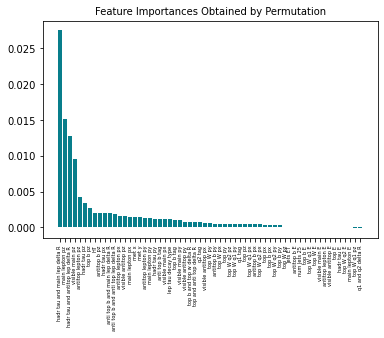

In [ ]:
print(importances.dtype)
print(importances)
print(importances.shape)
print(len(feature_names))
importances_pd = pd.DataFrame(data={
	'Attribute': feature_names,
	'Importance': importances
})
importances_pd = importances_pd.sort_values(by='Importance', ascending=False)
print(importances_pd.Importance)
plt.bar(x=importances_pd['Attribute'], height=importances_pd['Importance'], color='#087E8B')
# plt.bar([x for x in range(len(importances))], importances)
plt.title('Feature Importances Obtained by Permutation', size=10)
plt.xticks(fontsize=5, rotation='vertical')
# plt.subplots_adjust(bottom=0.15)
plt.savefig('figures/PA_FeatureImportance.pdf', bbox_inches="tight")
print(feature_names)

In [ ]:

""" Save trained model. """
import pickle

model.save_weights("models/particle_assignment_model")
model.save("models/particle_assignment_model")

with open('models/particle_assignment_model_history', 'wb') as file_pi:
		pickle.dump(history.history, file_pi)


INFO:tensorflow:Assets written to: models/particle_assignment_model\assets


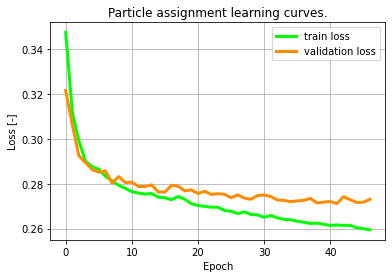

<Figure size 432x288 with 0 Axes>

In [ ]:
""" History plot. """
plt.plot(history.history['loss'], linewidth=3, color='lime', linestyle='-')
plt.plot(history.history['val_loss'], linewidth=3, color='darkorange', linestyle='-')
plt.title('Particle assignment learning curves.')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.savefig('figures/PA_learning_curve.pdf')
plt.show()
plt.clf()

1250008.npy
[[ 2.91895740e+07 -2.45080609e+04  6.02305518e+04 ...  5.17676959e+03
   3.04541539e+05  3.45954938e+05]
 [ 2.91895740e+07 -2.45080609e+04  6.02305518e+04 ...  5.17676959e+03
   3.04541539e+05  3.45954938e+05]
 [ 2.91895740e+07 -2.45080609e+04  6.02305518e+04 ...  5.17676959e+03
   3.04541539e+05  3.45954938e+05]
 ...
 [ 2.93410070e+07 -1.11117413e+05 -1.35704631e+04 ...  2.33328504e+03
  -2.23877802e+05  2.78388062e+05]
 [ 2.93410070e+07 -1.11117413e+05 -1.35704631e+04 ...  2.33328504e+03
  -2.23877802e+05  2.78388062e+05]
 [ 2.93410070e+07 -1.11117413e+05 -1.35704631e+04 ...  2.33328504e+03
  -2.23877802e+05  2.78388062e+05]]
67
(1, 67) (1848, 67)
1250017.npy
[[ 2.93600730e+07 -3.29827034e+04 -1.43740436e+04 ... -2.14355821e+05
   8.71434113e+05  9.08787875e+05]
 [ 2.93600730e+07 -3.29827034e+04 -1.43740436e+04 ... -2.14355821e+05
   8.71434113e+05  9.08787875e+05]
 [ 2.93600730e+07 -3.29827034e+04 -1.43740436e+04 ... -2.14355821e+05
   8.71434113e+05  9.08787875e+05]
 ..

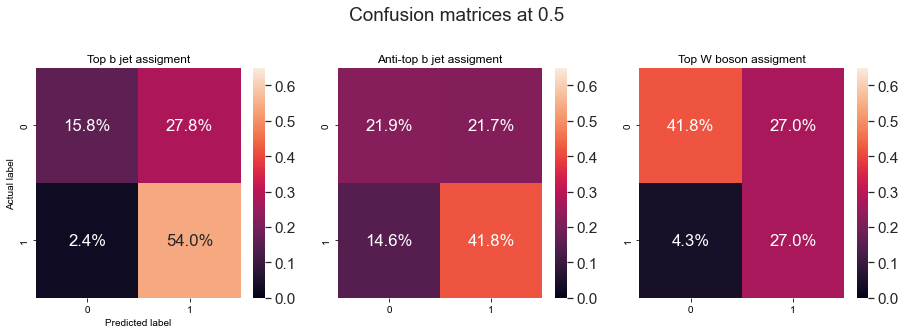

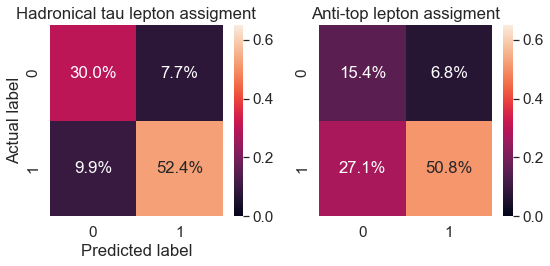

MATTHEWS CORRELATION
tf.Tensor(0.4101256, shape=(), dtype=float32)
tf.Tensor(0.25065333, shape=(), dtype=float32)
tf.Tensor(0.43836254, shape=(), dtype=float32)
tf.Tensor(0.6310127, shape=(), dtype=float32)
tf.Tensor(0.290894, shape=(), dtype=float32)


In [ ]:
""" Confusion matrices. """
# inspired by source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

from sklearn.metrics import confusion_matrix

test_predictions_baseline = model.predict(testing_generator)

n_batches = len(testing_generator)
y_test = np.concatenate([testing_generator[i][1] for i in range(n_batches)])


fig,axs = plt.subplots(1, 3, figsize=(13,4.8))

cm = confusion_matrix(y_test[:,0], test_predictions_baseline[:,0] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[0], vmin = 0, vmax = 0.65)
plt.suptitle("Confusion matrices at 0.5", fontsize=19)
plt.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams.update({'axes.labelsize': 'large'})
axs[0].title.set_text('{} assigment'.format("Top b jet"))
axs[0].set_ylabel('Actual label')
axs[0].set_xlabel('Predicted label')

cm = confusion_matrix(y_test[:,1], test_predictions_baseline[:,1] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[1], vmin = 0, vmax = 0.65)

axs[1].title.set_text('{} assigment'.format("Anti-top b jet"))


cm = confusion_matrix(y_test[:,2], test_predictions_baseline[:,2] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[2], vmin = 0, vmax = 0.65)

axs[2].title.set_text('{} assigment'.format("Top W boson"))

plt.tight_layout()
plt.savefig("figures/jest_assignment_btags_.pdf")
plt.show()


fig,axs = plt.subplots(1, 2, figsize=(8,4))

cm = confusion_matrix(y_test[:,3], test_predictions_baseline[:,3] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[0], vmin = 0, vmax = 0.65)
axs[0].title.set_text('{} assigment'.format("Hadronical tau lepton"))
axs[0].set_ylabel('Actual label')
axs[0].set_xlabel('Predicted label')

cm = confusion_matrix(y_test[:,4], test_predictions_baseline[:,4] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[1], vmin = 0, vmax = 0.65)
axs[1].title.set_text('{} assigment'.format("Anti-top lepton"))

plt.tight_layout()
plt.savefig("figures/cms.pdf")
plt.show()


print("MATTHEWS CORRELATION")
for i in range(5):
	print(matthews_correlation(y_test[:,i].astype('float32'),test_predictions_baseline[:,i].astype('float32')))
